# First stab at yahoo finance APIs

#### =====================================================
## Getting a feel for the data
#### =====================================================

### Installation of libraries (consider conda install for working env first)


### Importing relevant libraries

In [14]:
import ftplib
import io
import pandas as pd
import requests
import requests_html
import numpy as np

from pycaret.classification import *
from pycaret.regression import *

import yfinance as yf
from yahoo_fin.stock_info import get_data, get_top_crypto, get_analysts_info
import yahoo_fin.stock_info as si
import yahoo_fin.options as ops
from yahoo_fin.stock_info import *

import tensorflow as tf
import altair as alt

from benzinga import financial_data
from benzinga import news_data

import requests_cache

import mplfinance as mpf

import metricFxns
import vizFxns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 




### Yahoo_fin has two modules - stock_info and options.
---------
#### Stock_info has the following methods:

#### get_analysts_info(), get_balance_sheet(), get_cash_flow(), get_data(), get_day_gainers(), get_day_losers(), get_day_most_active(), get_holders(), get_income_statement(), get_live_price(), get_quote_table(), get_top_crypto(), get_stats(), get_stats_valuation(), tickers_dow(), tickers_nasdaq(), tickers_other(), tickers_sp500()
---------
#### And options has:

#### get_calls(), get_expiration_dates(), get_options_chain(), get_puts()
---------

#### And there are the methods you can’t use without requests_html are:

#### stock_info module, get_day_gainers(), get_day_most_active(), get_day_losers(), get_top_crypto(), get_expiration_dates()
---------

### Pulling data

In [7]:
# ticker: case insensitive ticker of the desired stock/bond
# start_date: date you want the data to start from (mm/dd/yyyy)
# end_date: date you want the data to end (mm/dd/yyyy)
# index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
# interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.
# get_data(ticker, start_date = None, end_date = None, index_as_date = True, interval = “1d”)

#Amazon only case
amazon_weekly= get_data("amzn", start_date="12/04/2009", end_date="3/06/2022", index_as_date = True, interval="1mo")
amazon_weekly = amazon_weekly.reset_index()
amazon_weekly = amazon_weekly.rename(columns={'index':'date'})
amazon_weekly.head()


,date,open,high,low,close,adjclose,volume,ticker
0,2010-01-01,6.8125,6.8305,5.9060,6.2705,6.2705,4617220000,AMZN
1,2010-02-01,6.1590,6.2430,5.6910,5.9200,5.9200,4202916000,AMZN
2,2010-03-01,5.9350,6.9095,5.8765,6.7885,6.7885,3160852000,AMZN
3,2010-04-01,6.7900,7.5545,6.5390,6.8550,6.8550,3460502000,AMZN
4,2010-05-01,6.8600,6.9720,5.8760,6.2730,6.2730,2818198000,AMZN


In [8]:

####################################################################################################################################################################

metaNasdaqDf = tickers_nasdaq(include_company_data = True)
timeseriesNasdaqDf = pd.DataFrame()
for ticker in tickers_nasdaq():
    try:
        timeseriesNasdaqDf = pd.concat([timeseriesNasdaqDf,get_data(ticker,start_date="01/16/2016" ,  end_date="3/06/2022", index_as_date = True, interval="1mo")])
    except:
        pass


timeseriesNasdaqDf = timeseriesNasdaqDf.reset_index()
timeseriesNasdaqDf = timeseriesNasdaqDf.rename(columns={'index':'date'})
timeseriesNasdaqDf.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2016-02-01,5.23,5.60,4.21,5.06,0.485294,198600,AACG
1,2016-03-01,5.06,5.50,4.52,5.19,0.497762,1375100,AACG
2,2016-04-01,5.31,6.91,5.15,5.69,0.545716,340200,AACG
3,2016-05-01,5.58,5.73,4.41,4.95,0.474744,188700,AACG
4,2016-06-01,4.93,5.70,4.57,4.63,0.444054,177800,AACG


In [9]:
metaNasdaqDf.head()
nasdaqTickers = list(timeseriesNasdaqDf['ticker'].unique())
print(len(nasdaqTickers))


4360


In [10]:
fullNasdaqDf = timeseriesNasdaqDf.merge(metaNasdaqDf, left_on='ticker', right_on='Symbol', how='left')
fullNasdaqDf.head()

,date,open,high,low,close,adjclose,volume,ticker,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,2016-02-01,5.23,5.60,4.21,5.06,0.485294,198600,AACG,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N
1,2016-03-01,5.06,5.50,4.52,5.19,0.497762,1375100,AACG,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N
2,2016-04-01,5.31,6.91,5.15,5.69,0.545716,340200,AACG,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N
3,2016-05-01,5.58,5.73,4.41,4.95,0.474744,188700,AACG,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N
4,2016-06-01,4.93,5.70,4.57,4.63,0.444054,177800,AACG,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N


### Testing out some visuals / limitations of altair

In [11]:
criteriaDf = fullNasdaqDf[(fullNasdaqDf['low']>100)&(fullNasdaqDf['high']<120)&(fullNasdaqDf['date']>datetime.datetime(2020,1,1))&(fullNasdaqDf['Market Category']=='Q')&(fullNasdaqDf['volume']>5000000)]
nasdaqCuttickers = list(criteriaDf['ticker'].unique())
nasdaqCut = fullNasdaqDf[fullNasdaqDf['ticker'].isin(nasdaqCuttickers)]

In [12]:
base = alt.Chart(nasdaqCut).mark_line().encode(
   x=alt.X("date",axis=alt.Axis(grid=False)),
   y=alt.Y("close",axis=alt.Axis(grid=False)),
   color=alt.Color('ticker', scale=alt.Scale(scheme='redblue')),
).properties(
   height=500, width=1800
)

quantiles = base.transform_quantile(
    "close", probs=[1,0.75,0.5,.25,0], groupby=["date"]
).mark_area(opacity=1).encode(alt.Y("value:Q", stack=None,axis=alt.Axis(grid=False)), alt.Color("prob:N", scale=alt.Scale(scheme='greys')))

quantiles

alt.Chart(...)

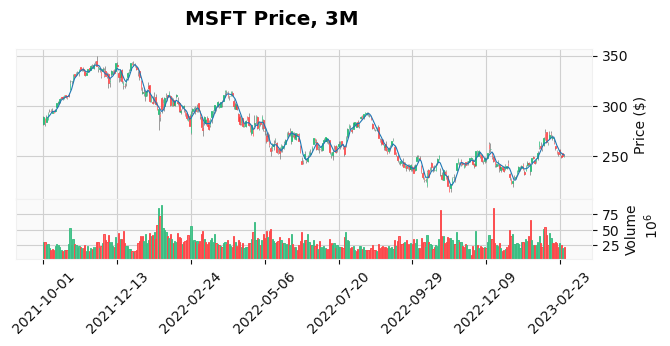

In [18]:
session = requests_cache.CachedSession("yfinance.cache")
session.headers["User-Agent"] = "prices-notebook/1.0"

msft = yf.Ticker("MSFT", session=session)
msft_df = msft.history(
    period="max", auto_adjust=False, back_adjust=False)

start = "2021-10-01"
end = "2023-02-28"

vizFxns.plot_candlestick(msft_df, "MSFT", "3M", start, end)

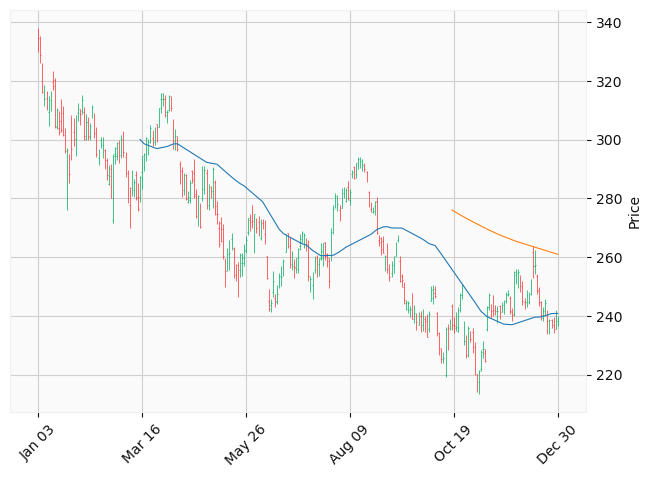

In [19]:
df = msft_df["2022-01-01":"2022-12-31"]
mpf.plot(df, mav=(50, 200), style="yahoo")

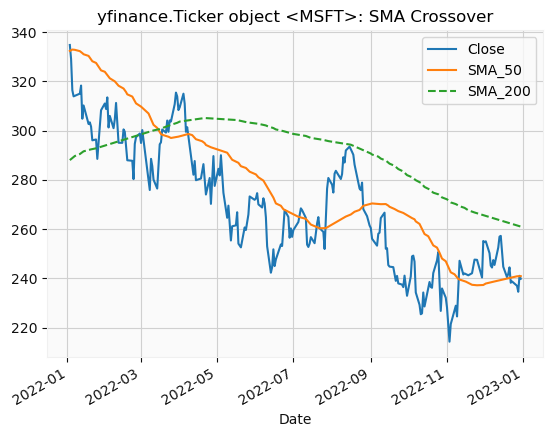

In [20]:
msft_df["SMA_50"] = msft_df["Close"].rolling(50).mean()
msft_df["SMA_200"] = msft_df["Close"].rolling(200).mean()
vizFxns.plot_crossover(msft, msft_df["2022-01-01":"2022-12-31"])

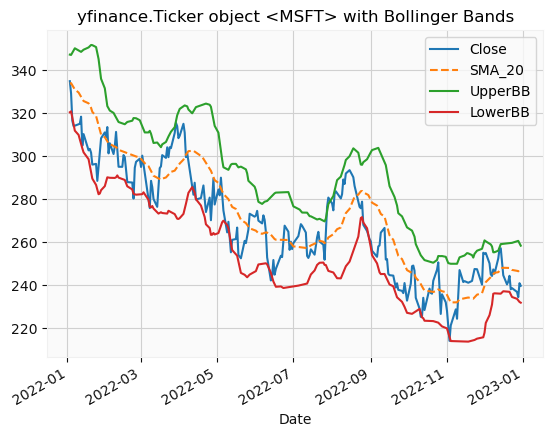

In [22]:
metricFxns.add_bollinger_bands(msft_df)
vizFxns.plot_bollinger(msft, msft_df["2022-01-01":"2022-12-31"])